In [1]:
import numpy as np
import matplotlib.pyplot as plt
import aml
import ase.db
from scipy.spatial import ConvexHull
from ase.visualize.plot import plot_atoms

model = aml.load_iap("./experiments/PtO/checkpoints/last.ckpt").cuda()

In [2]:
# DFT data
def scel_size(atoms):
    return atoms.symbols.count("O") + atoms.symbols.count("X")

def get_oxygen_coverage(atoms):
    return atoms.symbols.count("O") / scel_size(atoms)

rows = list(ase.db.connect('../data/Pt111_O_ads.db').select())
E_mix = []
energies_dft = []
cov = []
images = []
scel_sizes = []
for row in rows:
    atoms = row.toatoms()
    E_mix.append(row.mixing_energy)
    images.append(atoms)
    cov.append(get_oxygen_coverage(atoms))
    energies_dft.append(row.energy / scel_size(atoms))
    scel_sizes.append(scel_size(atoms))
E_mix = np.array(E_mix)
cov = np.array(cov)
energies_dft = np.array(energies_dft)
scel_sizes = np.array(scel_sizes)


In [3]:
# Predictions
calc = aml.simulations.AMLCalculator(model, neighborlist_backend="ase")
for i in range(len(images)):
    images[i].calc = calc

energies = np.array([image.get_potential_energy() / (image.symbols.count("O")+ image.symbols.count("X") ) for image in images])
ref_0 = images[0].get_potential_energy() / (images[0].symbols.count("X") + images[0].symbols.count("O"))
ref_1 = images[1].get_potential_energy() / (images[1].symbols.count("X") + images[1].symbols.count("O"))
E_mix_pred = energies - (1 - cov) * ref_0 - cov * ref_1

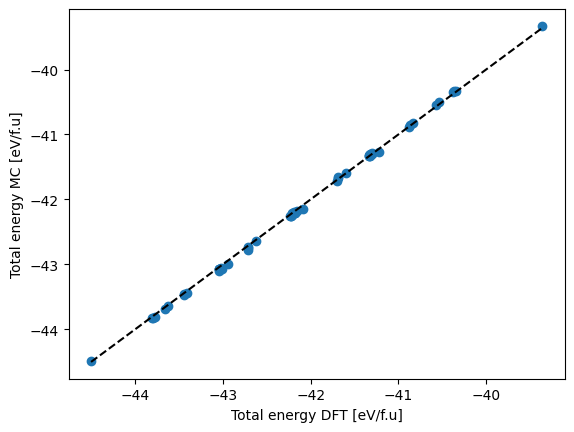

In [4]:
plt.figure()
plt.xlabel("Total energy DFT [eV/f.u]")
plt.ylabel("Total energy MC [eV/f.u]")
plt.plot(energies, energies_dft, "o")
plt.plot([energies.min(), energies.max()], [energies.min(), energies.max()], "k--")
plt.show()

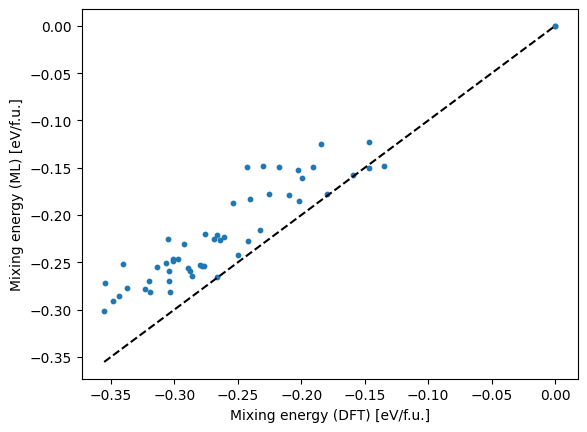

In [5]:
plt.figure()
plt.xlabel("Mixing energy (DFT) [eV/f.u.]")
plt.ylabel("Mixing energy (ML) [eV/f.u.]")
plt.scatter(E_mix, E_mix_pred, s=10)
plt.plot([min(E_mix), max(E_mix)], [min(E_mix), max(E_mix)], "k--")
plt.show()

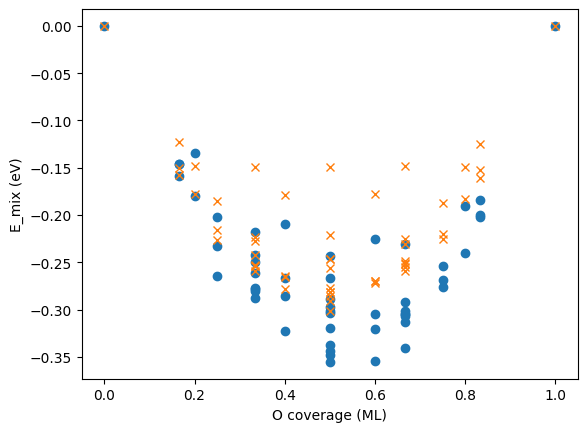

In [6]:
plt.figure()
plt.xlabel("O coverage (ML)")
plt.ylabel("E_mix (eV)")
plt.plot(cov, E_mix, "o")
plt.plot(cov, E_mix_pred, "x")
plt.show()